## Introduction 
**We will deeply discuss how we define the cost function and implement solvers through the code**.

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Defining the Cost Function
<div style="font-size: 130%;">

We therefore define our cost function as the sum of two main components:
a **position-related** cost and a **direction-related** cost.
</div>

$
\Large
J(\mathbf{p}, \mathbf{n})
\;=\;
J^{\text{pos}}(\mathbf{p})
\;+\;
J^{\text{dir}}(\mathbf{n})
$

<div style="font-size: 130%;">

Since we assume that ground truth trajectory data is unknow, balance between data fidelity and smoothness is very important. \
So we can define our two parts of the **cost** function as also two parts:
</div>

$
\Large
J^{\text{pos}}(\mathbf{p}) \;=\; J^{\text{pos}}_{fidelety} + J^{\text{pos}}_{smoothness}
$\
$
\Large
J^{\text{dir}}(\mathbf{n}) \;=\; J^{\text{dir}}_{fidelety} + J^{\text{dir}}_{smoothness}
$


---

<div style="font-size: 130%;">

Fidelity parts are relatively more intuative to figure out. \
Since we want our cost function to penalty our predictions when it is not close to the original (noisy) data, we can directly use `Sum Square Error` or `Mean Square Error`

</div>


$
\Large
J^{\text{pos}}_{fidelety}(\mathbf{p}) \;=\;
\sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y^p}_i\|^2
$\
$
\Large
J^{\text{dir}}_{fidelety}(\mathbf{n}) \;=\;
\sum_{i=1}^{N} \|\mathbf{n}_i - \mathbf{y^n}_i\|^2
$

---


<div style="font-size: 130%;">

To **penalize non-smoothness** in the reconstructed trajectory,  
we can examine the changes in position over discrete time steps.

The **difference** between two consecutive positions approximates the **velocity**: \
$
\Large
\mathbf{v}_i = \mathbf{p}_{i+1} - \mathbf{p}_i
$

Similarly, the **change** in velocity between two steps approximates the **acceleration**: \
$
\Large
\mathbf{a}_i = \mathbf{v}_i - \mathbf{v}_{i-1}
$

Substituting the expressions for velocity, we get: \
$
\Large
\mathbf{a}_i 
= (\mathbf{p}_{i+1} - \mathbf{p}_i) - (\mathbf{p}_i - \mathbf{p}_{i-1})
= \mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}
\;\approx\; \text{acceleration (rate of change of velocity)}.
$
\

Therefore, to **encourage smoothness**, we penalize large accelerations using the following regularization term: \
\
$
\Large
J^{\text{pos}}_{smoothness}(\mathbf{p}) \;=\;
\lambda_{1} \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2
$\
\
\
Exactly the same for direction, to **encourage smoothness**, \
\
$
\Large
J^{\text{dir}}_{smoothness}(\mathbf{n}) \;=\;
\lambda_{2} \sum_{i=2}^{N-1} \|\mathbf{n}_{i+1} - 2\mathbf{n}_i + \mathbf{n}_{i-1}\|^2
$

---

So here our **cost** function: \
$
\Large
J(\mathbf{p}, \mathbf{n}) \;=\;
\\
\sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y^p}_i\|^2
\;+\;
\\
\lambda_{1} \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2 
\;+\;
\\
\sum_{i=1}^{N} \|\mathbf{n}_i - \mathbf{y^n}_i\|^2
\;+\;
\\
\lambda_{2} \sum_{i=2}^{N-1} \|\mathbf{n}_{i+1} - 2\mathbf{n}_i + \mathbf{n}_{i-1}\|^2 
$
</div>

### Read data

In [2]:
data = np.load('drone_trajectory.npz')
trajectory = data.get('trajectory_noisy')

positions = trajectory[:, :3]  # y^p
nv        = trajectory[:, 3:6] # y^n

In [3]:

def cost(p, n, y_p, y_n, lam_1, lam_2):
    # position fidelity
    fidelity_p = np.sum(np.linalg.norm(p - y_p, axis=1)**2)

    # position smoothness (second difference)
    smooth_p = np.sum(
        np.linalg.norm(p[2:] - 2*p[1:-1] + p[:-2], axis=1)**2
    )

    # direction fidelity
    fidelity_n = np.sum(np.linalg.norm(n - y_n, axis=1)**2)

    # direction smoothness
    smooth_n = np.sum(
        np.linalg.norm(n[2:] - 2*n[1:-1] + n[:-2], axis=1)**2
    )

    return fidelity_p + lam_1 * smooth_p + fidelity_n + lam_2 * smooth_n

<div style="font-size: 130%;">

## Gradient of the Cost Function

$
\Large
\nabla J(\mathbf{p}, \mathbf{n})
\;=\;
\begin{bmatrix} \frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{p}} \\ \frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{n}} \end{bmatrix}
$

$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{p}}
\;=\;
\frac{\partial J^{\text{pos}}_{fidelety}(\mathbf{p})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{dir}}_{fidelety}(\mathbf{n})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{pos}}_{smoothness}(\mathbf{p})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{dir}}_{smoothness}(\mathbf{n})}{\partial \mathbf{p}}
$


$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{n}} 
\;=\;
\frac{\partial J^{\text{pos}}_{fidelety}(\mathbf{p})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{dir}}_{fidelety}(\mathbf{n})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{pos}}_{smoothness}(\mathbf{p})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{dir}}_{smoothness}(\mathbf{n})}{\partial \mathbf{n}}
$

Some of them **equals zero** when we get the derivative.

$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{p}}
\;=\;
\frac{\partial J^{\text{pos}}_{fidelety}(\mathbf{p})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{pos}}_{smoothness}(\mathbf{p})}{\partial \mathbf{p}}
$


$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{n}} 
\;=\;
\frac{\partial J^{\text{dir}}_{fidelety}(\mathbf{n})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{dir}}_{smoothness}(\mathbf{n})}{\partial \mathbf{n}}
$

---

### Gradient of Position Fidelity Term

$
\Large
J^{\text{pos}}_{\text{fidelity}}(\mathbf{p}) = \sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y}^p_i\|^2
$

Taking the derivative with respect to $\mathbf{p}_i$:

$
\Large
\frac{\partial J^{\text{pos}}_{\text{fidelity}}}{\partial \mathbf{p}_i} = 2(\mathbf{p}_i - \mathbf{y}^p_i)
$

---

### Gradient of Position Smoothness Term

$
\Large
J^{\text{pos}}_{\text{smoothness}}(\mathbf{p}) = \lambda_1 \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2
$

For each $\mathbf{p}_i$, we need to identify which terms in the sum contain $\mathbf{p}_i$:

- When $i=1$: appears in term $(i=2)$: $\|\mathbf{p}_3 - 2\mathbf{p}_2 + \mathbf{p}_1\|^2$
- When $2 \leq i \leq N-2$: appears in three terms:
  - $(i-1)$: $\|\mathbf{p}_i - 2\mathbf{p}_{i-1} + \mathbf{p}_{i-2}\|^2$ (coefficient: $+1$)
  - $(i)$: $\|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2$ (coefficient: $-2$)
  - $(i+1)$: $\|\mathbf{p}_{i+2} - 2\mathbf{p}_{i+1} + \mathbf{p}_i\|^2$ (coefficient: $+1$)
- When $i=N$: appears in term $(i=N-1)$: $\|\mathbf{p}_N - 2\mathbf{p}_{N-1} + \mathbf{p}_{N-2}\|^2$

Let $\mathbf{d}_i = \mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}$ for $i = 2, \ldots, N-1$.

$
\Large
\frac{\partial J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}_i} = \begin{cases}
2\lambda_1 \mathbf{d}_2 & i=1 \\
2\lambda_1 (\mathbf{d}_i - 2\mathbf{d}_{i+1} + \mathbf{d}_{i+2}) & 2 \leq i \leq N-2 \\
2\lambda_1 \mathbf{d}_{N-1} & i=N
\end{cases}
$

Or more compactly:

$
\Large
\frac{\partial J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}_i} = \begin{cases}
2\lambda_1 (\mathbf{p}_3 - 2\mathbf{p}_2 + \mathbf{p}_1) & i=1 \\
2\lambda_1 (\mathbf{p}_{i+2} - 4\mathbf{p}_{i+1} + 6\mathbf{p}_i - 4\mathbf{p}_{i-1} + \mathbf{p}_{i-2}) & 2 \leq i \leq N-2 \\
2\lambda_1 (\mathbf{p}_N - 2\mathbf{p}_{N-1} + \mathbf{p}_{N-2}) & i=N
\end{cases}
$

---

### Complete Gradient with Respect to Position

$
\Large
\frac{\partial J}{\partial \mathbf{p}_i} = 2(\mathbf{p}_i - \mathbf{y}^p_i) + \frac{\partial J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}_i}
$

---

### Gradient with Respect to Direction (Analogous)

By the same derivation:

$
\Large
\frac{\partial J}{\partial \mathbf{n}_i} = 2(\mathbf{n}_i - \mathbf{y}^n_i) + \frac{\partial J^{\text{dir}}_{\text{smoothness}}}{\partial \mathbf{n}_i}
$

where the smoothness gradient for direction follows the same structure as position.

</div>

In [4]:
def gradient(p, n, y_p, y_n, lam_1, lam_2):
    """
    Compute the gradient of the cost function.
    
    Parameters:
    -----------
    p : np.array, shape (N, 3)
        Current position estimates
    n : np.array, shape (N, 3)
        Current direction estimates
    y_p : np.array, shape (N, 3)
        Observed noisy positions
    y_n : np.array, shape (N, 3)
        Observed noisy directions
    lam_1 : float
        Position smoothness regularization parameter
    lam_2 : float
        Direction smoothness regularization parameter
    
    Returns:
    --------
    grad_p : np.array, shape (N, 3)
        Gradient with respect to positions
    grad_n : np.array, shape (N, 3)
        Gradient with respect to directions
    """
    N = p.shape[0]
    
    # Initialize gradients
    grad_p = np.zeros_like(p)
    grad_n = np.zeros_like(n)
    
    # ============================================
    # Gradient of position fidelity term
    # ============================================
    grad_p_fidelity = 2 * (p - y_p)
    
    # ============================================
    # Gradient of position smoothness term
    # ============================================
    grad_p_smoothness = np.zeros_like(p)
    
    # Boundary case: i = 0 (first point)
    # Only appears in the term for i=1: (p[2] - 2*p[1] + p[0])
    if N >= 3:
        grad_p_smoothness[0] = 2 * lam_1 * (p[2] - 2*p[1] + p[0])
    
    # Interior points: 1 <= i <= N-2
    # Point p[i] appears in three terms with coefficients: +1, -2, +1
    # This gives: p[i+2] - 4*p[i+1] + 6*p[i] - 4*p[i-1] + p[i-2]
    for i in range(1, N-1):
        if i == 1:
            # p[1] appears in terms i=1 (as -2) and i=2 (as +1)
            grad_p_smoothness[i] = 2 * lam_1 * (
                -2*(p[2] - 2*p[1] + p[0])  # derivative from term i=1
            )
            if N >= 4:
                grad_p_smoothness[i] += 2 * lam_1 * (p[3] - 2*p[2] + p[1])  # derivative from term i=2
        elif i == N-2:
            # p[N-2] appears in terms i=N-3 (as +1) and i=N-2 (as -2)
            grad_p_smoothness[i] = 2 * lam_1 * (
                (p[i] - 2*p[i-1] + p[i-2])  # derivative from term i=N-3
                - 2*(p[i+1] - 2*p[i] + p[i-1])  # derivative from term i=N-2
            )
        else:
            # Interior points appear in three consecutive terms
            grad_p_smoothness[i] = 2 * lam_1 * (
                (p[i] - 2*p[i-1] + p[i-2])  # derivative from term (i-1)
                - 2*(p[i+1] - 2*p[i] + p[i-1])  # derivative from term (i)
                + (p[i+2] - 2*p[i+1] + p[i])  # derivative from term (i+1)
            )
    
    # Boundary case: i = N-1 (last point)
    if N >= 3:
        grad_p_smoothness[N-1] = 2 * lam_1 * (p[N-1] - 2*p[N-2] + p[N-3])
    
    # Combine position gradients
    grad_p = grad_p_fidelity + grad_p_smoothness
    
    # ============================================
    # Gradient of direction terms (same structure)
    # ============================================
    grad_n_fidelity = 2 * (n - y_n)
    
    grad_n_smoothness = np.zeros_like(n)
    
    if N >= 3:
        grad_n_smoothness[0] = 2 * lam_2 * (n[2] - 2*n[1] + n[0])
    
    for i in range(1, N-1):
        if i == 1:
            grad_n_smoothness[i] = 2 * lam_2 * (
                -2*(n[2] - 2*n[1] + n[0])
            )
            if N >= 4:
                grad_n_smoothness[i] += 2 * lam_2 * (n[3] - 2*n[2] + n[1])
        elif i == N-2:
            grad_n_smoothness[i] = 2 * lam_2 * (
                (n[i] - 2*n[i-1] + n[i-2])
                - 2*(n[i+1] - 2*n[i] + n[i-1])
            )
        else:
            grad_n_smoothness[i] = 2 * lam_2 * (
                (n[i] - 2*n[i-1] + n[i-2])
                - 2*(n[i+1] - 2*n[i] + n[i-1])
                + (n[i+2] - 2*n[i+1] + n[i])
            )
    
    if N >= 3:
        grad_n_smoothness[N-1] = 2 * lam_2 * (n[N-1] - 2*n[N-2] + n[N-3])
    
    # Combine direction gradients
    grad_n = grad_n_fidelity + grad_n_smoothness
    
    return grad_p, grad_n


# Test the gradient function
data = np.load("drone_trajectory.npz")
trajectory = data['trajectory']
trajectory_noisy = data['trajectory_noisy']

y_p = trajectory_noisy[:, :3]  # noisy positions
y_n = trajectory_noisy[:, 3:]  # noisy directions

p = y_p.copy()  # initial guess
n = y_n.copy()

lam_1 = 0.1
lam_2 = 0.1

grad_p, grad_n = gradient(p, n, y_p, y_n, lam_1, lam_2)

print("Gradient shape (positions):", grad_p.shape)
print("Gradient shape (directions):", grad_n.shape)
print("\nGradient norm (positions):", np.linalg.norm(grad_p))
print("Gradient norm (directions):", np.linalg.norm(grad_n))

Gradient shape (positions): (200, 3)
Gradient shape (directions): (200, 3)

Gradient norm (positions): 2.974671758898433
Gradient norm (directions): 3.20997624748686


## Line Search Methods

Line search methods are iterative optimization algorithms that follow this general pattern:

$
\Large
\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha \mathbf{d}_k
$

where:
- $\mathbf{x}_k$ is the current iterate
- $\alpha > 0$ is a **constant step size** (learning rate)
- $\mathbf{d}_k$ is the search direction

---

### First-Order Method: Gradient Descent

The search direction is the **negative gradient**:

$
\Large
\mathbf{d}_k = -\nabla J(\mathbf{x}_k)
$

This direction guarantees descent because:

$
\Large
\nabla J(\mathbf{x}_k)^T \mathbf{d}_k = -\|\nabla J(\mathbf{x}_k)\|^2 < 0
$

**Update rule:**

$
\Large
\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha \nabla J(\mathbf{x}_k)
$

The step size $\alpha$ must be chosen carefully:
- Too large: overshooting, divergence
- Too small: slow convergence

---

### Second-Order Method: Newton's Method

The search direction uses **second-order information** (Hessian):

$
\Large
\mathbf{d}_k = -\mathbf{H}_k^{-1} \nabla J(\mathbf{x}_k)
$

where $\mathbf{H}_k = \nabla^2 J(\mathbf{x}_k)$ is the Hessian matrix.

**Update rule:**

$
\Large
\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha \mathbf{H}_k^{-1} \nabla J(\mathbf{x}_k)
$

Newton's method has **quadratic convergence** near the minimum when $\mathbf{H}_k$ is positive definite.

For our problem, we typically use $\alpha = 1.0$ for Newton's method since the Hessian already provides optimal scaling.

---
## Hessian Matrix of the Cost Function

The Hessian matrix contains all second-order partial derivatives:

$
\Large
\mathbf{H} = \nabla^2 J(\mathbf{p}, \mathbf{n}) = 
\begin{bmatrix}
\frac{\partial^2 J}{\partial \mathbf{p} \partial \mathbf{p}} & \frac{\partial^2 J}{\partial \mathbf{p} \partial \mathbf{n}} \\
\frac{\partial^2 J}{\partial \mathbf{n} \partial \mathbf{p}} & \frac{\partial^2 J}{\partial \mathbf{n} \partial \mathbf{n}}
\end{bmatrix}
$

Since $J(\mathbf{p}, \mathbf{n})$ separates into independent position and direction terms:

$
\Large
\mathbf{H} = 
\begin{bmatrix}
\mathbf{H}_{\mathbf{p}} & \mathbf{0} \\
\mathbf{0} & \mathbf{H}_{\mathbf{n}}
\end{bmatrix}
$

where $\frac{\partial^2 J}{\partial \mathbf{p} \partial \mathbf{n}} = \mathbf{0}$ (positions and directions are decoupled).

---

### Hessian of Position Terms

$
\Large
\mathbf{H}_{\mathbf{p}} = \frac{\partial^2 J}{\partial \mathbf{p}^2} = \frac{\partial^2 J^{\text{pos}}_{\text{fidelity}}}{\partial \mathbf{p}^2} + \frac{\partial^2 J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}^2}
$

**Hessian of Fidelity Term:**

$
\Large
J^{\text{pos}}_{\text{fidelity}} = \sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y}^p_i\|^2
$

The second derivative gives:

$
\Large
\frac{\partial^2 J^{\text{pos}}_{\text{fidelity}}}{\partial \mathbf{p}_i \partial \mathbf{p}_j} = \begin{cases}
2\mathbf{I}_{3 \times 3} & i = j \\
\mathbf{0}_{3 \times 3} & i \neq j
\end{cases}
$

This contributes $2\mathbf{I}$ to the diagonal blocks.

---

**Hessian of Smoothness Term:**

$
\Large
J^{\text{pos}}_{\text{smoothness}} = \lambda_1 \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2
$

For a single term $\|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2$, the Hessian has a **pentadiagonal structure**.

Let's compute: $\mathbf{d}_i = \mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}$

$
\Large
\|\mathbf{d}_i\|^2 = \mathbf{d}_i^T \mathbf{d}_i
$

The second derivatives are:

$
\Large
\frac{\partial^2 \|\mathbf{d}_i\|^2}{\partial \mathbf{p}_j \partial \mathbf{p}_k} = 
\begin{cases}
2 \cdot 1 \cdot \mathbf{I} = 2\mathbf{I} & (j,k) = (i-1, i-1) \text{ or } (i+1, i+1) \\
2 \cdot 4 \cdot \mathbf{I} = 8\mathbf{I} & (j,k) = (i, i) \\
2 \cdot (-2) \cdot \mathbf{I} = -4\mathbf{I} & (j,k) \in \{(i-1,i), (i,i-1), (i,i+1), (i+1,i)\} \\
2 \cdot 1 \cdot \mathbf{I} = 2\mathbf{I} & (j,k) \in \{(i-1,i+1), (i+1,i-1)\} \\
\mathbf{0} & \text{otherwise}
\end{cases}
$

**Structure of $\mathbf{H}_{\mathbf{p}}$:**

The Hessian is a **block pentadiagonal matrix** where each block is $3 \times 3$:

$
\Large
\mathbf{H}_{\mathbf{p}} = 2\mathbf{I} + 2\lambda_1
\begin{bmatrix}
\mathbf{A}_1 & \mathbf{B}_1 & \mathbf{C}_1 & & & \\
\mathbf{B}_1^T & \mathbf{A}_2 & \mathbf{B}_2 & \mathbf{C}_2 & & \\
\mathbf{C}_1^T & \mathbf{B}_2^T & \mathbf{A}_3 & \mathbf{B}_3 & \ddots & \\
& \mathbf{C}_2^T & \ddots & \ddots & \ddots & \mathbf{C}_{N-3} \\
& & \ddots & \mathbf{B}_{N-2}^T & \mathbf{A}_{N-1} & \mathbf{B}_{N-1} \\
& & & \mathbf{C}_{N-3}^T & \mathbf{B}_{N-1}^T & \mathbf{A}_N
\end{bmatrix}
$

where the diagonal blocks are:
- $\mathbf{A}_1 = \mathbf{I}$ (boundary)
- $\mathbf{A}_i = 6\mathbf{I}$ for $2 \leq i \leq N-1$ (interior)
- $\mathbf{A}_N = \mathbf{I}$ (boundary)

and off-diagonal blocks:
- $\mathbf{B}_i = -4\mathbf{I}$ (adjacent interactions)
- $\mathbf{C}_i = \mathbf{I}$ (two-step interactions)

---

### Hessian of Direction Terms

By symmetry:

$
\Large
\mathbf{H}_{\mathbf{n}} = 2\mathbf{I} + 2\lambda_2 \cdot [\text{same pentadiagonal structure}]
$

---

### Properties of the Hessian

1. **Symmetric**: $\mathbf{H}^T = \mathbf{H}$
2. **Block-diagonal**: Position and direction terms are decoupled
3. **Sparse**: Pentadiagonal structure (only 5 diagonals have non-zero blocks)
4. **Positive definite** when $\lambda_1, \lambda_2 > 0$: guarantees a unique global minimum

</div>

FIRST-ORDER LINE SEARCH (Gradient Descent)
Iter 0: Cost = 4.239724, ||grad|| = 4.376371e+00
Converged at iteration 15

SECOND-ORDER LINE SEARCH (Newton's Method)
Iter 0: Cost = 4.239724, ||grad|| = 4.376371e+00
Converged at iteration 1


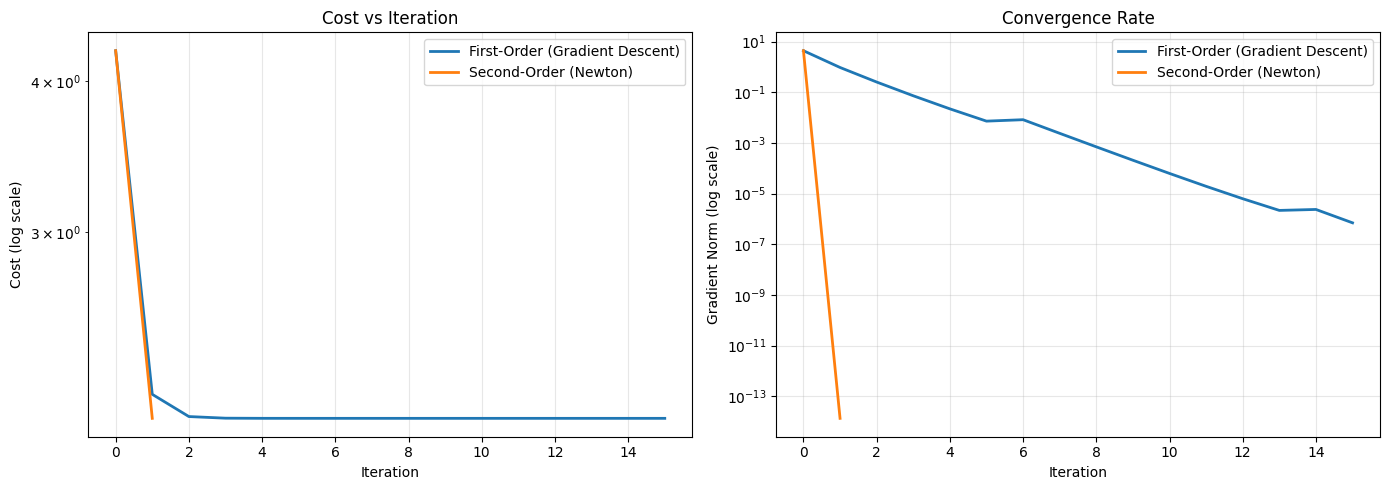

In [5]:
def hessian(p, n, y_p, y_n, lam_1, lam_2):
    """
    Compute the Hessian matrix of the cost function.
    
    For our quadratic cost function, the Hessian is constant (independent of p, n).
    
    The Hessian has block structure:
    H = [[H_pp,  0   ],
         [0,     H_nn]]
    
    Returns:
    --------
    H_p : np.array, shape (N*3, N*3)
        Hessian with respect to positions (flattened)
    H_n : np.array, shape (N*3, N*3)
        Hessian with respect to directions (flattened)
    """
    N = p.shape[0]
    
    # Hessian of fidelity term: 2*I (diagonal)
    # Hessian of smoothness term: structured sparse matrix
    
    # For computational efficiency, we'll build the Hessian as a sparse matrix
    # But for this project, let's use dense matrices
    
    H_p = np.zeros((N*3, N*3))
    H_n = np.zeros((N*3, N*3))
    
    # Fidelity term contributes 2*I to the Hessian
    for i in range(N*3):
        H_p[i, i] += 2
        H_n[i, i] += 2
    
    # Smoothness term contribution
    # For each second difference term, we need to compute the Hessian
    # d_i = p[i+1] - 2*p[i] + p[i-1]
    # ||d_i||^2 = d_i^T * d_i
    # Hessian of ||d_i||^2 with respect to the involved points
    
    for i in range(1, N-1):
        # Points involved: p[i-1], p[i], p[i+1]
        # Each coordinate (x,y,z) is independent
        
        for coord in range(3):
            idx_im1 = (i-1)*3 + coord
            idx_i = i*3 + coord
            idx_ip1 = (i+1)*3 + coord
            
            # Second derivative of ||p[i+1] - 2*p[i] + p[i-1]||^2
            # This gives a 3x3 block with coefficients:
            # [1, -2, 1; -2, 4, -2; 1, -2, 1]
            
            H_p[idx_im1, idx_im1] += 2 * lam_1 * 1
            H_p[idx_im1, idx_i] += 2 * lam_1 * (-2)
            H_p[idx_im1, idx_ip1] += 2 * lam_1 * 1
            
            H_p[idx_i, idx_im1] += 2 * lam_1 * (-2)
            H_p[idx_i, idx_i] += 2 * lam_1 * 4
            H_p[idx_i, idx_ip1] += 2 * lam_1 * (-2)
            
            H_p[idx_ip1, idx_im1] += 2 * lam_1 * 1
            H_p[idx_ip1, idx_i] += 2 * lam_1 * (-2)
            H_p[idx_ip1, idx_ip1] += 2 * lam_1 * 1
            
            # Same for directions
            H_n[idx_im1, idx_im1] += 2 * lam_2 * 1
            H_n[idx_im1, idx_i] += 2 * lam_2 * (-2)
            H_n[idx_im1, idx_ip1] += 2 * lam_2 * 1
            
            H_n[idx_i, idx_im1] += 2 * lam_2 * (-2)
            H_n[idx_i, idx_i] += 2 * lam_2 * 4
            H_n[idx_i, idx_ip1] += 2 * lam_2 * (-2)
            
            H_n[idx_ip1, idx_im1] += 2 * lam_2 * 1
            H_n[idx_ip1, idx_i] += 2 * lam_2 * (-2)
            H_n[idx_ip1, idx_ip1] += 2 * lam_2 * 1
    
    return H_p, H_n


def backtracking_line_search(cost_func, x_current, direction, gradient_current, 
                              cost_current, c1=1e-4, rho=0.5, alpha_init=1.0, 
                              max_iter=50):
    """
    Backtracking line search using Armijo condition.
    
    Parameters:
    -----------
    cost_func : callable
        Function that takes x and returns cost
    x_current : tuple (p, n)
        Current position and direction
    direction : tuple (d_p, d_n)
        Search direction
    gradient_current : tuple (grad_p, grad_n)
        Current gradient
    cost_current : float
        Current cost value
    c1 : float
        Armijo constant
    rho : float
        Backtracking factor
    alpha_init : float
        Initial step size
    max_iter : int
        Maximum backtracking iterations
    
    Returns:
    --------
    alpha : float
        Step size that satisfies Armijo condition
    """
    alpha = alpha_init
    p_curr, n_curr = x_current
    d_p, d_n = direction
    grad_p, grad_n = gradient_current
    
    # Compute directional derivative: grad^T * d
    directional_derivative = np.sum(grad_p * d_p) + np.sum(grad_n * d_n)
    
    for _ in range(max_iter):
        # Compute new point
        p_new = p_curr + alpha * d_p
        n_new = n_curr + alpha * d_n
        
        # Compute new cost
        cost_new = cost_func(p_new, n_new)
        
        # Check Armijo condition
        if cost_new <= cost_current + c1 * alpha * directional_derivative:
            return alpha
        
        # Reduce step size
        alpha *= rho
    
    return alpha


def line_search_first_order(p_init, n_init, y_p, y_n, lam_1, lam_2, 
                             max_iter=1000, tol=1e-6, verbose=True):
    """
    First-order line search (Gradient Descent) with backtracking.
    
    Returns:
    --------
    p, n : optimized position and direction
    history : dict with 'cost', 'grad_norm', 'alpha' lists
    """
    p = p_init.copy()
    n = n_init.copy()
    
    history = {
        'cost': [],
        'grad_norm': [],
        'alpha': []
    }
    
    # Cost function wrapper
    def cost_func(p, n):
        return cost(p, n, y_p, y_n, lam_1, lam_2)
    
    for iteration in range(max_iter):
        # Compute cost and gradient
        J = cost_func(p, n)
        grad_p, grad_n = gradient(p, n, y_p, y_n, lam_1, lam_2)
        
        grad_norm = np.sqrt(np.linalg.norm(grad_p)**2 + np.linalg.norm(grad_n)**2)
        
        history['cost'].append(J)
        history['grad_norm'].append(grad_norm)
        
        if verbose and iteration % 50 == 0:
            print(f"Iter {iteration}: Cost = {J:.6f}, ||grad|| = {grad_norm:.6e}")
        
        # Check convergence
        if grad_norm < tol:
            print(f"Converged at iteration {iteration}")
            break
        
        # Search direction: negative gradient
        d_p = -grad_p
        d_n = -grad_n
        
        # Line search for step size
        alpha = backtracking_line_search(
            cost_func, (p, n), (d_p, d_n), (grad_p, grad_n), J
        )
        
        history['alpha'].append(alpha)
        
        # Update
        p = p + alpha * d_p
        n = n + alpha * d_n
    
    return p, n, history


def line_search_newton(p_init, n_init, y_p, y_n, lam_1, lam_2, 
                        max_iter=100, tol=1e-6, verbose=True):
    """
    Second-order line search (Newton's Method) with backtracking.
    
    Returns:
    --------
    p, n : optimized position and direction
    history : dict with 'cost', 'grad_norm', 'alpha' lists
    """
    p = p_init.copy()
    n = n_init.copy()
    
    history = {
        'cost': [],
        'grad_norm': [],
        'alpha': []
    }
    
    def cost_func(p, n):
        return cost(p, n, y_p, y_n, lam_1, lam_2)
    
    for iteration in range(max_iter):
        # Compute cost, gradient, and Hessian
        J = cost_func(p, n)
        grad_p, grad_n = gradient(p, n, y_p, y_n, lam_1, lam_2)
        H_p, H_n = hessian(p, n, y_p, y_n, lam_1, lam_2)
        
        grad_norm = np.sqrt(np.linalg.norm(grad_p)**2 + np.linalg.norm(grad_n)**2)
        
        history['cost'].append(J)
        history['grad_norm'].append(grad_norm)
        
        if verbose and iteration % 10 == 0:
            print(f"Iter {iteration}: Cost = {J:.6f}, ||grad|| = {grad_norm:.6e}")
        
        # Check convergence
        if grad_norm < tol:
            print(f"Converged at iteration {iteration}")
            break
        
        # Newton direction: H^(-1) * grad
        # Flatten gradients
        grad_p_flat = grad_p.reshape(-1)
        grad_n_flat = grad_n.reshape(-1)
        
        # Solve linear systems: H * d = -grad
        try:
            d_p_flat = np.linalg.solve(H_p, -grad_p_flat)
            d_n_flat = np.linalg.solve(H_n, -grad_n_flat)
        except np.linalg.LinAlgError:
            print("Hessian is singular, falling back to gradient descent")
            d_p_flat = -grad_p_flat
            d_n_flat = -grad_n_flat
        
        # Reshape back
        d_p = d_p_flat.reshape(p.shape)
        d_n = d_n_flat.reshape(n.shape)
        
        # Line search for step size
        alpha = backtracking_line_search(
            cost_func, (p, n), (d_p, d_n), (grad_p, grad_n), J
        )
        
        history['alpha'].append(alpha)
        
        # Update
        p = p + alpha * d_p
        n = n + alpha * d_n
    
    return p, n, history


# Test both methods
print("="*60)
print("FIRST-ORDER LINE SEARCH (Gradient Descent)")
print("="*60)
p_opt_1st, n_opt_1st, hist_1st = line_search_first_order(
    y_p, y_n, y_p, y_n, lam_1=0.1, lam_2=0.1, max_iter=500, verbose=True
)

print("\n" + "="*60)
print("SECOND-ORDER LINE SEARCH (Newton's Method)")
print("="*60)
p_opt_2nd, n_opt_2nd, hist_2nd = line_search_newton(
    y_p, y_n, y_p, y_n, lam_1=0.1, lam_2=0.1, max_iter=100, verbose=True
)

# Plot convergence comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogy(hist_1st['cost'], label='First-Order (Gradient Descent)', linewidth=2)
axes[0].semilogy(hist_2nd['cost'], label='Second-Order (Newton)', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost (log scale)')
axes[0].set_title('Cost vs Iteration')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(hist_1st['grad_norm'], label='First-Order (Gradient Descent)', linewidth=2)
axes[1].semilogy(hist_2nd['grad_norm'], label='Second-Order (Newton)', linewidth=2)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Gradient Norm (log scale)')
axes[1].set_title('Convergence Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()